

---

# Intro - Autoencoder

**Plan** - Produce proof of concept autoencoder architecture.

**Purpose**: Produce a robust, flexible and stable autoencoder architecture that can be used for dimensionality reduction on input data at work. The overall purpose is to be able to use this to encode data that has thousands of features into a latent space representation with fewer (to reduce time complexity of modelling) whilst preserving predictive performance.

**Hypothesis**: with automatic HP tuning an autoencoder can be used to reduce dimensionality of input data, whilst retaining adequate information to accurately reproduce input data.

**Methodology**: Test on multiple datasets - first the Iris dataset, then Pima Indians, then finally credit card fraud dataset. Evaluate and assess model architecture and visualize latent space using PCA/UMAP etc. See below for details on evaluation methods.


# First dataset - iris dataset
---
## Data sourcing and processing


In [ ]:

#import packages :

import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

from google.colab import drive

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  # Check if drive is mounted by looking for the mount point in the file system.
  # This is a more robust approach than relying on potentially internal variables.
  import os
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

#basics
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
!pip install umap-learn
!pip install optuna
from umap import UMAP
import optuna


#table one
!pip install tableone
from tableone import TableOne

#torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim  # Add this import
from torch.utils.data import Subset
from torch.utils.data import DataLoader, random_split, Dataset

#sklearn
!pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris  # Import the Iris dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, accuracy_score

#modelling and evaluation
from imblearn.over_sampling import RandomOverSampler

#Kmeans
from scipy.optimize import linear_sum_assignment




---

# Autoencoder (Iris dataset)


1.   First we import our data

2.   We will then get a Table One of the input data, and later of the reconstructed output data, to compare.

3. We will check the distribution/separation of our latent space by plotting it in 2 dimensions - therefore we will fix our latent space dimensionality HP at 2.

4. Finally as a final evaluation method we will do some basic predictive modelling on the input space vs the reconstructed data, and finally on the latent space representation.



In [ ]:
# **Set device for GPU acceleration**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != 'cuda':
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")


#---------------- Dimensionality reduction ----------------#


# Load the Iris dataset
iris = load_iris()
data = iris.data
target = iris.target
target_names = iris.target_names

# Create a Pandas DataFrame for TableOne
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target  # Add the target column
iris_columns = iris_df.columns.tolist()

# Print dataset information and TableOne
print(f"The dataset length is {str(len(iris_df))}")
print(f"The number of columns is {str(len(iris_columns))}")
print(f"The column names are {str(iris_columns)} \n")
print("Table one of input data: ")
table1 = TableOne(iris_df, columns=iris_columns, groupby='target', pval=True)
print(table1)

# Scale the data for UMAP
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)



Cuda setup successful
The dataset length is 150
The number of columns is 5
The column names are ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target'] 

Table one of input data: 
                              Grouped by target                                                    
                                        Missing    Overall          0          1          2 P-Value
n                                                      150         50         50         50        
sepal length (cm), mean (SD)                  0  5.8 (0.8)  5.0 (0.4)  5.9 (0.5)  6.6 (0.6)  <0.001
sepal width (cm), mean (SD)                   0  3.1 (0.4)  3.4 (0.4)  2.8 (0.3)  3.0 (0.3)  <0.001
petal length (cm), mean (SD)                  0  3.8 (1.8)  1.5 (0.2)  4.3 (0.5)  5.6 (0.6)  <0.001
petal width (cm), mean (SD)                   0  1.2 (0.8)  0.2 (0.1)  1.3 (0.2)  2.0 (0.3)  <0.001



In this trial of the autoencoder, in order to get a meaningful latent space representation we are going to fix latent space dimensionality at 2, so we can compare it to our UMAP.

In [1]:
# **Set device for GPU acceleration**

# Set device for GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    print("WARNING: GPU is not available. The model will run on the CPU, which might be slower.")
else:
    print("Cuda setup successful")

# Load and preprocess the iris dataset
iris = load_iris()
data = iris.data

# Scale data to the range [0, 1] for better convergence
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Convert to PyTorch Dataset
class IrisDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

dataset = IrisDataset(data, iris.target)

# split into train + validation set, to be dynamically split later
#our train/validation split will make up 80% of data when combined
train_val_size = int(0.8 * len(dataset))
#test size will then in theory be 20% of data
test_size = len(dataset) - train_val_size
train_val_set, test_set = random_split(dataset, [train_val_size, test_size])

# Define Flexible Autoencoder architecture
class FlexibleAutoencoder(nn.Module):
    def __init__(self, input_dim, num_encoder_layers, encoder_neurons, num_decoder_layers, decoder_neurons, activations, dropout_prob, use_batchnorm):
        super(FlexibleAutoencoder, self).__init__()

        self.input_dim = input_dim # Store the original input dimension of the input data (because output has to have the same number of dimensions)

        # Build the encoder
        encoder = []
        in_dim = input_dim

        #each itertation of this loop is adding another layer
        for i in range(num_encoder_layers):
            #define output dimensionality for this layer
            out_dim = encoder_neurons[i] if i < num_encoder_layers - 1 else 2  # Latent space dimensionality is fixed at 2
            #add the layer
            encoder.append(nn.Linear(in_dim, out_dim))
            #conditionally use batchnorm if HP calls for it
            if use_batchnorm and i < num_encoder_layers - 1:
                encoder.append(nn.BatchNorm1d(out_dim))
            encoder.append(getattr(nn, activations[i])())  # Use activations from encoder_activations list
            if dropout_prob > 0:
                encoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim
        self.encoder = nn.Sequential(*encoder)

        # Build the decoder
        decoder = []
        in_dim = 2  # Latent space dimensionality fixed at two so we can visualize in 2D, like UMAP

        for i in range(num_decoder_layers):

            out_dim = decoder_neurons[i] if i < num_decoder_layers - 1 else self.input_dim  # Output layer has input_dim neurons
            decoder.append(nn.Linear(in_dim, out_dim))
            if use_batchnorm and i < num_decoder_layers - 1:
                decoder.append(nn.BatchNorm1d(out_dim))
            decoder.append(getattr(nn, activations[num_encoder_layers + i])())  # Use activations from decoder_activations list
            if dropout_prob > 0 and i < num_decoder_layers - 1:
                decoder.append(nn.Dropout(dropout_prob))
            in_dim = out_dim

        self.decoder = nn.Sequential(*decoder)

        assert self.input_dim == out_dim, f"Input dimension ({self.input_dim}) does not match output dimension ({out_dim})"


    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed


# Training and evaluation functions
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=50):
    model.to(device)  # Move model to the correct device (GPU or CPU)

    # Lists to track the loss for each epoch
    train_loss_history = []
    val_loss_history = []

    # Loop over the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0.0

        # Training loop - we use _ to throw away targets as they are not used here
        for batch, _ in train_loader:  # Unpack data
            batch = batch.to(device)  # Move data to the device

            optimizer.zero_grad()  # Zero out the gradients
            latent, reconstructed = model(batch)  # Pass batch to the model
            loss = criterion(reconstructed, batch)  # Calculate loss using reconstructed and batch
            loss.backward()  # Backpropagate the loss
            optimizer.step()  # Update model parameters

            total_train_loss += loss.item()  # Accumulate the training loss

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0.0

        with torch.no_grad():  # No gradients needed for validation
            for batch, _ in val_loader:  # Unpack data, ignore target using _
                batch = batch.to(device)  # Move data to the device

                latent, reconstructed = model(batch) # Pass batch to the model
                loss = criterion(reconstructed, batch)  # Calculate the loss using reconstructed and batch
                total_val_loss += loss.item()  # Accumulate the validation loss

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

    return train_loss_history, val_loss_history

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch, _ in dataloader:  # Unpack data, ignore target using _
            batch = batch.to(device)  # Move data to the device

            _, outputs = model(batch)  # Pass batch to the model
            loss = criterion(outputs, batch)  # Calculate the loss using reconstructed and batch
            total_loss += loss.item()
    return total_loss / len(dataloader)

# K-Fold Cross-Validation with Optuna
from sklearn.model_selection import KFold
import torch.optim as optim

# K-Fold Cross-Validation with Optuna
def objective(trial):
    # Number of encoder and decoder layers
    num_encoder_layers = trial.suggest_int("num_encoder_layers", 2, 5)
    num_decoder_layers = trial.suggest_int("num_decoder_layers", 2, 5)

    # List of possible activation functions
    activation_choices = ["ReLU", "Tanh", "LeakyReLU", "Sigmoid"]

    # Vary the number of neurons for each encoder and decoder layer
    encoder_neurons = []
    decoder_neurons = []

    for i in range(num_encoder_layers):
        encoder_neurons.append(trial.suggest_int(f"encoder_neurons_{i}", 4, 128, step=4))

    for i in range(num_decoder_layers):
        decoder_neurons.append(trial.suggest_int(f"decoder_neurons_{i}", 4, 128, step=4))

    activations = [trial.suggest_categorical(f"encoder_activation_{i}", activation_choices) for i in range(num_encoder_layers)]
    activations += [trial.suggest_categorical(f"decoder_activation_{i}", activation_choices) for i in range(num_decoder_layers)]

    # Set dropout and batch normalization parameters
    dropout_prob = trial.suggest_float("dropout_prob", 0.0, 0.5)
    use_batchnorm = trial.suggest_categorical("use_batchnorm", [True, False])

    # Suggest batch_size to Optuna:
    batch_size = trial.suggest_int("batch_size", 16, 64) # Suggest batch sizes between 16 and 64

    # Create the model
    model = FlexibleAutoencoder(
        input_dim=data.shape[1],
        num_encoder_layers=num_encoder_layers,
        encoder_neurons=encoder_neurons,
        num_decoder_layers=num_decoder_layers,
        decoder_neurons=decoder_neurons,
        activations=activations,
        dropout_prob=dropout_prob,
        use_batchnorm=use_batchnorm
    )

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=trial.suggest_loguniform("lr", 1e-5, 1e-1))
    criterion = torch.nn.MSELoss()  # Using MSE loss as it's an autoencoder

    # K-Fold Cross Validation
    kfold = KFold(n_splits=4, shuffle=True)
    fold_losses = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
      #dynamically create train and val subsets
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # DataLoader for the current fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)

        val_batch_size = min(batch_size, len(val_subset))  #in case validation size is greater than batch size
        val_loader = DataLoader(val_subset, batch_size=val_batch_size, shuffle=False, drop_last=False)

        # Train the model for the current fold
        train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=100)

        # Calculate the average validation loss for the fold
        fold_losses.append(val_loss_history[-1])  # Get last epoch's validation loss

    # Return the average loss across all folds
    avg_fold_loss = sum(fold_losses) / len(fold_losses)

    return avg_fold_loss


# Optimize hyperparameters using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

# Evaluate on holdout test set
best_params = study.best_params
num_encoder_layers = best_params["num_encoder_layers"]
num_decoder_layers = best_params["num_decoder_layers"]

# Extract encoder and decoder neurons based on the number of layers
encoder_neurons = [best_params[f"encoder_neurons_{i}"] for i in range(num_encoder_layers)]
decoder_neurons = [best_params[f"decoder_neurons_{i}"] for i in range(num_decoder_layers)]

# Extract activation functions based on the number of layers
activations = [best_params[f"encoder_activation_{i}"] for i in range(num_encoder_layers)]
activations += [best_params[f"decoder_activation_{i}"] for i in range(num_decoder_layers)]

final_model = FlexibleAutoencoder(
    input_dim=data.shape[1],
    num_encoder_layers=num_encoder_layers,
    encoder_neurons=encoder_neurons,  # Use the extracted encoder_neurons
    num_decoder_layers=num_decoder_layers,
    decoder_neurons=decoder_neurons,  # Use the extracted decoder_neurons
    activations=activations,  # Use the extracted activations
    dropout_prob=best_params["dropout_prob"],
    use_batchnorm=best_params["use_batchnorm"],
).to(device)

test_loader = DataLoader(test_set, batch_size=best_params["batch_size"])
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
criterion = nn.MSELoss()

# Train final model
train_model(final_model, DataLoader(train_val_set, batch_size=best_params["batch_size"], shuffle=True), test_loader, optimizer, criterion) # Added test_loader as the validation loader here

# Evaluate on the test set
test_loss = evaluate(final_model, test_loader, criterion)
print("Test loss on holdout set:", test_loss)


NameError: name 'torch' is not defined

Now let's do a UMAP Dimensionality reduction on the test set. We will then encode the test set and compare the two.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


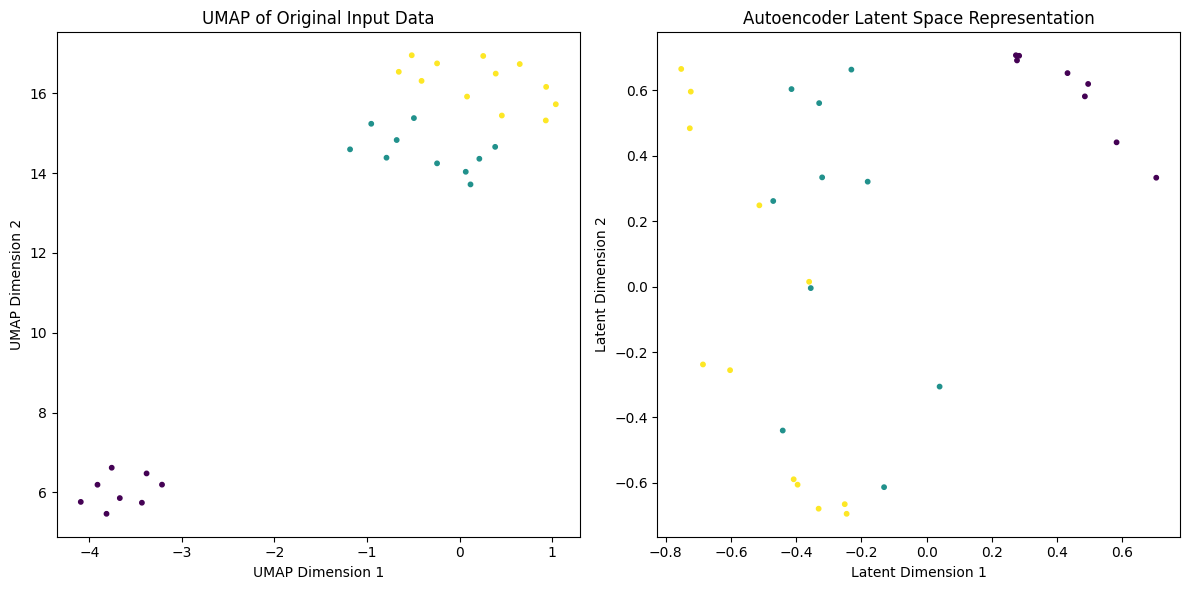

In [ ]:

final_model.eval()

# Function to encode data and preserve labels
def encode_with_labels(data_loader, model, device):
    latent_space = []
    labels = []

    with torch.no_grad():
        for data_batch, target_batch in data_loader:  # data_loader now yields (data, target)
            data_batch = data_batch.to(device)
            encoded = model.encoder(data_batch)
            latent_space.append(encoded.cpu())
            labels.append(target_batch.cpu())

    latent_space = torch.cat(latent_space, dim=0)
    labels = torch.cat(labels, dim=0)
    return latent_space.numpy(), labels.numpy()

# DataLoader for the test set
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Encode the test set and preserve labels
latent_space, labels = encode_with_labels(test_loader, final_model, device)

# Apply UMAP directly to the original test set (preprocessed input data)
test_data, test_labels = [], []
for data, target in test_loader:
    test_data.append(data)
    test_labels.append(target)
test_data = torch.cat(test_data).numpy()
test_labels = torch.cat(test_labels).numpy()

umap_reducer = umap.UMAP(random_state=42)
test_umap = umap_reducer.fit_transform(test_data)  # UMAP on original input data

# Plot UMAP and latent space side-by-side for comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# UMAP Visualization
ax[0].scatter(test_umap[:, 0], test_umap[:, 1], c=test_labels, cmap="viridis", s=10)
ax[0].set_title("UMAP of Original Input Data")
ax[0].set_xlabel("UMAP Dimension 1")
ax[0].set_ylabel("UMAP Dimension 2")

# Latent Space Visualization
ax[1].scatter(latent_space[:, 0], latent_space[:, 1], c=labels, cmap="viridis", s=10)
ax[1].set_title("Autoencoder Latent Space Representation")
ax[1].set_xlabel("Latent Dimension 1")
ax[1].set_ylabel("Latent Dimension 2")

# Show the plots
plt.tight_layout()
plt.show()


So we can see from the latent space that we are getting some degree of class separation, albeit not as much as the original class separation. So now we need to measure that. We will apply a K-means clustering algorith and compare the results to the true labels, to give us an approximate idea of how well we could model on the latent space representation.

K-Means Clustering Results:
Adjusted Rand Index (ARI): 0.4079
Normalized Mutual Information (NMI): 0.5620


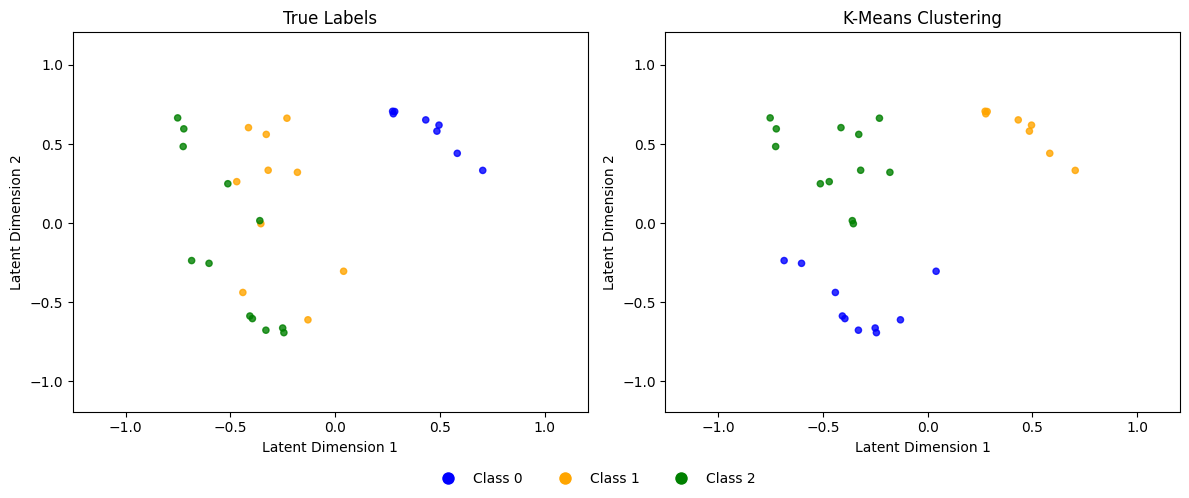

In [ ]:
# Encode the test set and preserve labels
latent_space, labels = encode_with_labels(test_loader, final_model, device)

#K-Means Evaluation Function
def evaluate_kmeans(latent_space, true_labels, n_clusters):
    """
    Runs K-Means clustering on the latent space and evaluates the clustering quality.

    TO DO - implement accuracy with Hungarian algorithm
    """
    # Step 1: Apply K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    predicted_labels = kmeans.fit_predict(latent_space)

    # Step 2: Evaluation Metrics
    # Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels, predicted_labels)

    # Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    print("K-Means Clustering Results:")
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Step 3: Visualization with a unified 3-color scheme
    color_map = {0: 'blue', 1: 'orange', 2: 'green'}  # Define a simple 3-color scheme

    def plot_scatter(latent_space, labels, title, subplot_idx):
        colors = [color_map[label] for label in labels]  # Map labels to colors
        plt.subplot(1, 2, subplot_idx)
        plt.scatter(latent_space[:, 0], latent_space[:, 1], c=colors, s=20, alpha=0.8)
        plt.title(title)
        plt.xlabel("Latent Dimension 1")
        plt.ylabel("Latent Dimension 2")
        plt.xlim(latent_space[:, 0].min()-0.5, latent_space[:, 0].max()+0.5)
        plt.ylim(latent_space[:, 1].min()-0.5, latent_space[:, 1].max()+0.5)

    plt.figure(figsize=(12, 5))

    # Plot True Labels
    plot_scatter(latent_space, true_labels, "True Labels", 1)

    # Plot K-Means Clustering Results
    plot_scatter(latent_space, predicted_labels, "K-Means Clustering", 2)

    # Add a color key
    plt.figlegend(
        handles=[
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f"Class {label}")
            for label, color in color_map.items()
        ],
        loc='lower center', ncol=3, frameon=False
    )

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

    return ari, nmi

if __name__ == "__main__":
    evaluate_kmeans(latent_space, labels, 3)

Next let's do some basic analysis of the test data, so we can compare to reconstructed data.


In [ ]:
#test_Set is currently a torch subset object which in a nutshell, only contains the indices of the test set data as references (usually for memory efficiency reasons)

def subset_to_df(input_subset, original_dataset):
  """
  Converts a subset of the larger original dataframe to pandas dataframe

  Args:

  input_subset (torch subset) : subset representing data to be converted to a pd dataframe
  original_dataset (sklearn bunch object) : original dataset that this input subset is taken from
  """

  indices = input_subset.indices #get indices of test set data from subset object using indices method

  output_data = original_dataset.data[indices] #access the data attribute of the original bunch object and select from this data the subset at [indices]
  test_targets = original_dataset.target[indices] #access the target attribute for labels

  df = pd.DataFrame(output_data, columns=original_dataset.feature_names)  # Create DataFrame with feature names
  df['target'] = test_targets  # Add the target column

  df[original_dataset.feature_names] = df[original_dataset.feature_names].astype(float)#convert to correct datatypes

  return df


test_set_df = subset_to_df(test_set, iris)



TO DO - compare means, distributions etc



---

# Auto push to github




In [ ]:
import datetime
import os

def commit_to_github(commit_msg):
  """
  Funct to autopush to github
  """

  # Navigate to the repository directory
  %cd /content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice

  !git add .

  with open('/content/drive/MyDrive/IAM/PAT.txt', 'r') as file:
        github_pat = file.read().strip()
  os.environ['GITHUB_PAT'] = github_pat

  !git remote add origin "https://github.com/archiegoodman2/machine_learning_practice"

  # Replace with your actual username and email
  USERNAME="archiegoodman2"
  EMAIL="archiegoodman2011@gmail.com"

  # Set global username and email configuration
  !git config --global user.name "$USERNAME"
  !git config --global user.email "$EMAIL"

  now = datetime.datetime.now()
  current_datetime = now.strftime("%Y-%m-%d %H:%M")

  # Set remote URL using the PAT from environment variable
  !git remote set-url origin https://{os.environ['GITHUB_PAT']}@github.com/archiegoodman2/machine_learning_practice.git

  # Replace with your desired commit message
  COMMIT_MESSAGE = str(current_datetime) + " " + str(commit_msg)

  # Commit the changes
  !git commit -m "$COMMIT_MESSAGE"

  # Push to origin (force push if necessary)
  !git push origin master

  return 1

commit_to_github(" added K Means clustering as a method of assessing autoencoder")


/content/drive/MyDrive/Colab_Notebooks/Deep_Learning_Practice
error: remote origin already exists.
[master 0d7b80c] 2024-12-17 17:35  added K Means clustering as a method of assessing autoencoder
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite nn_autoencoder_iris.ipynb (94%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 34.62 KiB | 2.88 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/archiegoodman2/machine_learning_practice.git
   d47972a..0d7b80c  master -> master


1